# Kinematics

This file aims to help beginers better understand Forward and inverse Kinematics with visual 2D and 3D illustrations as well as  real robot movement.

Kinimatics are the science of motion without regard of the force and torque that cause the motion. When we discuss kinematics we consider two types: Forwards Kinematics and Inverse Kinematics.

Consider a robot arm, if we know the length of each link and the rotation angle of each joint, we can use Forward kinematics to calculate the position of any point on the arm.
\
If we know the length of each link and the end point position the arm, and we want to derive the angle of each joint needed to obtain that position, we are talking about Inverse Kinematics


## 1. One servo kinematics

Example: a robot arm with one link, the forward and inverse kinematics are simple:

Forward kinematics:
$$
x = l cos(\theta)
$$
$$
y = l sin(\theta)
$$

Inverse kinematics:
$$
\theta = arccos(\frac{x}{l})
$$

### 1.1 Forward kinematics

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from spatialmath import *
import math as math
%matplotlib widget

You can change the angle **$\alpha$** to plot different gesture of lower legs

In [5]:
alpha = np.radians(50)
alpha_degree = alpha * 180/np.pi
lu = 3

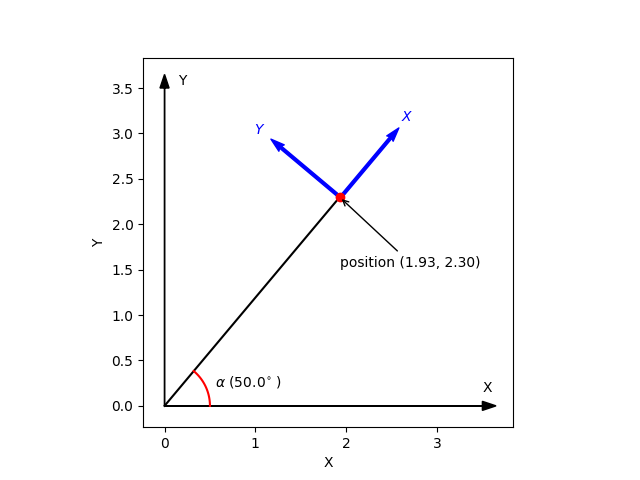

In [6]:
#calculate the coordinate of the end effector
x = lu * np.cos(alpha)
y = lu * np.sin(alpha)

#plot
T = SE2([lu*np.cos(alpha), lu*np.sin(alpha)]) * SE2(alpha)
points = np.zeros((2, 2))

fig, ax = plt.subplots()
ax.set_xlim(-3.5, 3.5)
ax.set_ylim(-3.5, 3.5)

#plot x arrow
ax.arrow(0, 0, 3.5, 0, head_width=0.1, head_length=0.15, ec='k', fc='k')
ax.text(3.5, 0.2, 'X', ha='left', va='center')
#plot y arrow
ax.arrow(0, 0, 0, 3.5, head_width=0.1, head_length=0.15, ec='k', fc='k')
ax.text(0.2, 3.5, 'Y', ha='center', va='bottom')
# plot upper leg
points[0,1] = lu*np.cos(alpha)
points[1,1] = lu*np.sin(alpha)
plt.plot(points[0], points[1],'-k')
# plot angle
angles = np.linspace(0,float(alpha))
xs = 0.5 * np.cos(angles)
ys = 0.5 * np.sin(angles)
plt.plot(xs, ys, '-r')
plt.text(xs[int(len(angles)/2)]+0.1, ys[int(len(angles)/2)], "$\\alpha$ (%s$^{\circ}$ )" % round(math.degrees(alpha), 2))
# plot the coordinate of the end point with an arrow pointed at it
plt.plot(points[0,1],points[1,1],'or')
ax.annotate(
    "position (%.2f, %.2f)" % (points[0,1],points[1,1]),
    xy=(points[0,1],points[1,1]), xycoords='data',
    xytext=(0, -50), textcoords='offset points',
    arrowprops=dict(arrowstyle="->"))

T.plot()
ax.grid(False)

Send command to the robot to make it move

In [18]:
import socket
import time
from hrst_sender import SocketSender

#replace with the actual ip address of the robot
HOST = '192.168.137.29'
command = '1D %s|45' % alpha_degree
print(command)
sender = SocketSender(HOST)
sender.send_pushup_command(command)

1D 29.999999999999996|45
Connected to server 192.168.137.29:8001
Connection closed


### 1.2 Inverse kinematics

In [7]:
alpha_inv = np.arccos(x/lu)
print(round(alpha*180/np.pi, 2))

50.0


## 2. Two servo kinematics

### 2.1 Forward Kinematics

#### (1) Geometric solution
For a robot with two joints, geometric method is still decent to solve forward kinematics
$$
x_1 = l_u cos(\theta)
$$
$$
y_1 = l_u cos(\theta)
$$
$$
x_2 = l_l cos(\theta + \gamma) + x_1
$$
$$
y_2 = l_l cos(\theta + \gamma) + y_1
$$

In [8]:
ll = 4

You can change the angles to see different plot

[ 6.05690381 -0.56028226]


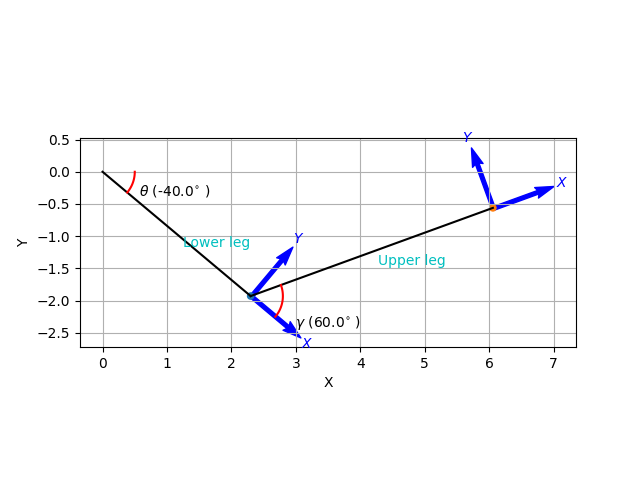

In [9]:
theta = np.radians(-40)
gamma = np.radians(60)
points = np.zeros((2, 3))
points[0,1] = lu*np.cos(theta)
points[1,1] = lu*np.sin(theta)
points[0,2] = lu*np.cos(theta) + ll*np.cos(theta+gamma)
points[1,2] = lu*np.sin(theta) + ll*np.sin(theta+gamma)
print(points[:,2])
#plot
T0_1 = SE2([lu*np.cos(theta), lu*np.sin(theta)]) * SE2(theta)
T1_2 = SE2([ll*np.cos(gamma), ll*np.sin(gamma)]) * SE2(gamma)
T0_2 = T0_1 * T1_2

fig, ax = plt.subplots()
# plot upper leg
plt.plot([points[0,0],points[0,1]], [points[1,0],points[1,1]],'-k')
plt.text((points[0,0] + points[0,1])/2 + 0.1, (points[1,0] + points[1,1])/2 - 0.2, "Lower leg", color = 'c')
# plot angle
angles = np.linspace(0,float(theta))
xs = 0.5 * np.cos(angles)
ys = 0.5 * np.sin(angles)
plt.plot(xs, ys, '-r')
plt.text(xs[int(len(angles)/2)]+0.1, ys[int(len(angles)/2)]-0.2, "$\\theta$ (%s$^{\circ}$ )" % round(math.degrees(theta), 2))
T0_1.plot()
# plot lower leg
plt.plot([points[0,1],points[0,2]], [points[1,1],points[1,2]],'-k')
plt.text((points[0,1] + points[0,2])/2 + 0.1, (points[1,1] + points[1,2])/2 - 0.2, "Upper leg", color = 'c')
#plot angle
angles = np.linspace(float(theta), float(theta)+float(gamma))
xs = points[0,1] + 0.5 * np.cos(angles)
ys = points[1,1] + 0.5 * np.sin(angles)
plt.plot(xs, ys, '-r')
plt.text(xs[int(len(angles)/2)]+0.2, ys[int(len(angles)/2)]-0.4, "$\gamma$ (%s$^{\circ}$ )" % round(math.degrees(gamma), 2))
T0_2.plot()
plt.grid(True)

#### (2) Transformation Matrix

If the number of joints exceeds 3, geometric method could be much more tedious. Here we can use homogeneous transformation matrix to get the final result

We still consider a 2 joint robot arm. The 2D Transformations from one joint to the next can be expressed as a 3-dimensional homogeneous transformation matrix for rotation around z axis

$$
\begin{bmatrix}
\cos(\theta) & -\sin(\theta) & 0 & x\\
\sin(\theta) & \cos(\theta) & 0 & y\\
0 & 0 & 1 & 0\\
0 & 0 & 0 & 1\\
\end{bmatrix}
$$

Where $\theta$ is the rotation angle and x,y are the components of the translation vector

For our case, from the first joint to the second, the transformation matrix is:
$$
_1^0T =
\begin{bmatrix}
\cos(\theta) & -\sin(\theta) & 0 & l_u \cos(\theta)\\
\sin(\theta) & \cos(\theta) & 0 & l_u \sin(\theta)\\
0 & 0 & 1 & 0\\
0 & 0 & 0 & 1\\
\end{bmatrix}
$$
from the second joint to the manipulator, the transformation is:
$$
_2^1T =
\begin{bmatrix}
\cos(\gamma) & -\sin(\gamma) & 0 & l_l \cos(\gamma)\\
\sin(\gamma) & \cos(\gamma) & 0 & l_l \sin(\gamma)\\
0 & 0 & 1 & 0\\
0 & 0 & 0 & 1\\
\end{bmatrix}
$$
The transition from joint 1 to the manipulator is the multiplication of $_0^1T$ and $_1^2T$:
$$
_2^0T = _1^0T _2^1T =
\begin{bmatrix}
\cos(\theta)\cos(\gamma)-\sin(\theta)\sin(\gamma) & -\cos(\theta)\sin(\gamma) - \sin(\theta)\cos(\gamma) & 0 & l_u \cos(\theta) + l_l\cos(\theta + \gamma)\\
\sin(\theta)\cos(\gamma) + \cos(\theta)\sin(\gamma) & -\sin(\theta)\sin(\gamma) + \cos(\theta)\cos(\gamma) & 0 & l_u\sin(\theta) + l_l\sin(\theta + \gamma)\\
0 & 0 & 1 & 0\\
0 & 0 & 0 & 1\\
\end{bmatrix}
$$

The manipulator position can be obtained by:
$$
_2^0P = _2^0T _2^2P = _2^0T
\begin{bmatrix}
0\\
0\\
0\\
1
\end{bmatrix}
$$
We can see that the last column is the quadrant of the end point manuipulator

In the following we use Spatial Maths for Python from Peter Corke as our Python module


In [10]:
# create 2d rotation Matrix for theta
R = SO2(theta)
print(R)

   0.766     0.6428    
  -0.6428    0.766     



In [11]:
# create a 2d homogeneous translation matrix
# calculate the translation vector
T = SE2([lu*np.cos(theta), lu*np.sin(theta)])
print(T)

   1         0         2.298     
   0         1        -1.928     
   0         0         1         



In [12]:
# combining the two
T1 = SE2([lu*np.cos(theta), lu*np.sin(theta)]) * SE2(theta)
print(T1)

   0.766     0.6428    2.298     
  -0.6428    0.766    -1.928     
   0         0         1         



Here is a simple example showing the robot arm move from an initial state to your set angles

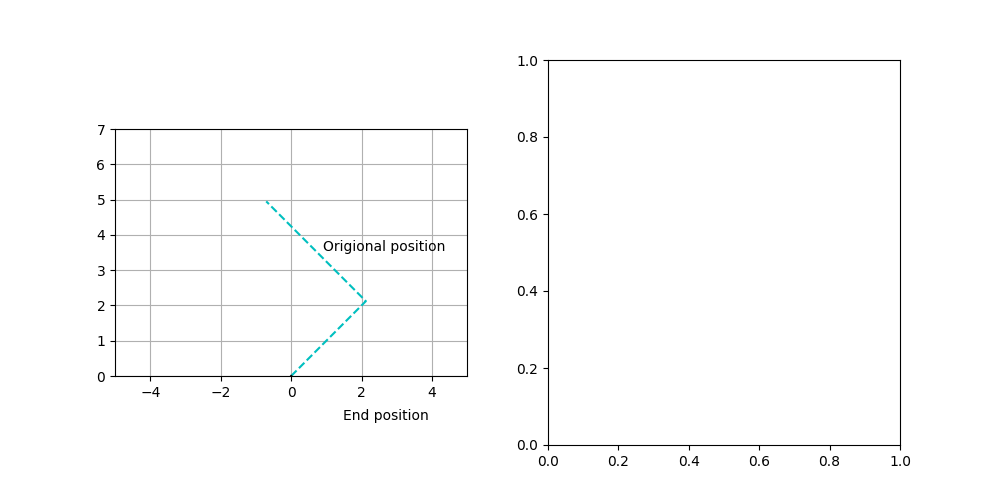

In [13]:
import matplotlib.animation as animation
import time
#set defaut angles
t = np.radians(45)
g = np.radians(90)
#convert angles to be sent to robot(can be optimized, not necessary)
theta_robot = theta - np.pi
gamma_robot = gamma
#set plot frames and angles of each frame
ani_num = 20
angles_t_ani = np.linspace(t, theta, ani_num)
angles_g_ani = np.linspace(g, gamma, ani_num)
#send command to robot
time.sleep(2)
#HOST = '192.168.1.90'
#command = 'ANI %s|%s' % (theta_robot, gamma_robot)
#print(command)
#sender = SocketSender(HOST)
#sender.send_pushup_command(command)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
left1, bottom1, width1, height1 = ax1.get_position().bounds
left2, bottom2, width2, height2 = ax2.get_position().bounds
ax1.set_position([left1-0.01, bottom1+0.138, width1, height1*0.6415])
ax2.set_position([left2, bottom2, width2, height2])

T1 = SE2([lu*np.cos(theta), lu*np.sin(theta)]) * SE2(theta)
T2 = SE2([ll*np.cos(gamma), ll*np.sin(gamma)]) * SE2(gamma)
T3 = T1*T2
points = np.zeros((2, 2))
points_defaut = np.zeros((2,3))                        
#plot defaut state
points_defaut[0,1] = lu*np.cos(t)
points_defaut[1,1] = lu*np.sin(t)
points_defaut[0,2] = lu*np.cos(t) + ll*np.cos(t+g)
points_defaut[1,2] = lu*np.sin(t) + ll*np.sin(t+g)
ax1.plot(points_defaut[0], points_defaut[1],'--c')
ax1.text((points_defaut[0,2] + points_defaut[0,1])/2 + 0.2, (points_defaut[1,2] + points_defaut[1,1])/2, 'Origional position')
# plot upper leg
points[0,1] = lu*np.cos(theta)
points[1,1] = lu*np.sin(theta)
ax1.plot(points[0], points[1],'-k')
# plot lower leg
points[0,0] = points[0,1]
points[1,0] = points[1,1]
points[0,1] = lu*np.cos(theta) + ll*np.cos(theta+gamma)
points[1,1] = lu*np.sin(theta) + ll*np.sin(theta+gamma)
ax1.plot(points[0], points[1],'-k')
ax1.text((points[0,1] + points[0,0])/2 - 2.7, (points[1,1] + points[1,0])/2, 'End position')
ax1.set_xlim(-5.0, 5.0)
ax1.set_ylim(0.0, 7.0)
ax1.grid(True)

def animate(i):
    points = np.zeros((2,2))
    points_defaut = np.zeros((2,3))
    theta_ani = angles_t_ani[i]
    gamma_ani = angles_g_ani[i]
    T1a = SE2([lu*np.cos(theta_ani), lu*np.sin(theta_ani)]) * SE2(theta_ani)
    T2a = SE2([ll*np.cos(gamma_ani), ll*np.sin(gamma_ani)]) * SE2(gamma_ani)
    T3a = T1a * T2a
    ax2.cla()

    #plot defaut state
    points_defaut[0,1] = lu*np.cos(t)
    points_defaut[1,1] = lu*np.sin(t)
    points_defaut[0,2] = lu*np.cos(t) + ll*np.cos(t+g)
    points_defaut[1,2] = lu*np.sin(t) + ll*np.sin(t+g)
    ax2.plot(points_defaut[0], points_defaut[1],'--c')
    # plot upper leg
    points[0,1] = lu*np.cos(theta_ani)
    points[1,1] = lu*np.sin(theta_ani)
    ax2.plot(points[0], points[1],'-k')
    # plot angle
    angles = np.linspace(0,float(theta_ani))
    xs = 0.5 * np.cos(angles)
    ys = 0.5 * np.sin(angles)
    ax2.plot(xs, ys, '-r')
    ax2.text(xs[int(len(angles)/2)]+0.1, ys[int(len(angles)/2)]-0.2, "$\\theta$ (%s$^{\circ}$ )" % round(math.degrees(theta_ani),2))
    T1a.plot()
    # plot lower leg
    points[0,0] = points[0,1]
    points[1,0] = points[1,1]
    points[0,1] = lu*np.cos(theta_ani) + ll*np.cos(theta_ani+gamma_ani)
    points[1,1] = lu*np.sin(theta_ani) + ll*np.sin(theta_ani+gamma_ani)
    ax2.plot(points[0], points[1],'-k')
    #plot angle
    angles = np.linspace(float(theta_ani), float(theta_ani)+float(gamma_ani))
    xs = points[0,0] + 0.5 * np.cos(angles)
    ys = points[1,0] + 0.5 * np.sin(angles)
    ax2.plot(xs, ys, '-r')
    ax2.text(xs[int(len(angles)/2)]+0.2, ys[int(len(angles)/2)]-0.4, "$\gamma$ (%s$^{\circ}$ )" % round(math.degrees(gamma_ani),2))
    T3a.plot()
    ax2.set_xlim(-5.0, 5.0)
    ax2.set_ylim(0.0, 7.0)
    ax2.grid(True)
time.sleep(0.1)
ani = animation.FuncAnimation(fig, animate, ani_num, interval=1, blit=True, repeat = False)
plt.show()

In [14]:
# Now it's your turn: 

# 1.think and write a function to calculate the transformation matrix
# input: a rotation angle in degrees and the link length l in meters
# return: the transformation matrix
def transformationM(angle, l):
    ## write your code inside this and delete the 'pass' ##
    pass

# 2. write a function using transformation matrix to solve the forward kinematics problem
# input: matrix [ theta, gamma ]
# return: a 2*3 matrix, the first column is the origin, the second column is the second joint's coordinate, the third column is the end manipulator's coordinate
def mpForwardKin(angles):
    ## write your code inside this and delete the 'pass' ##
    pass


In [15]:
# Answer: for Minipupper write function for forward kinematic using only np
def transformationM(angle, l):
    c = np.cos(np.radians(angle))
    s = np.sin(np.radians(angle))
    return np.array([[c, -s, 0, l*c], [s, c, 0, l*s], [0, 0, 1, 0], [0, 0, 0, 1]])
def mpForwardKin(angles):
    lu = 3 # from urdf
    ll = 4 # measured, includes the rubber foot
    T1 = transformationM(angles[0], lu)
    T2 = transformationM(angles[1], ll)
    T3 = T1.dot(T2)
    P1 = T1.dot(np.array([0,0,0,1]))[0:3]
    P2 = T3.dot(np.array([0,0,0,1]))[0:3]
    return np.array([[0, P1[0], P2[0]], [0, P1[1], P2[1]]])

In [16]:
P = mpForwardKin([-40, 40])
print(P)

[[ 0.          2.29813333  6.29813333]
 [ 0.         -1.92836283 -1.92836283]]


### 2.2 Inverse Kinematics

Given a point in the base coordinate system calculate theta and gamma so that the end point of the lower leg is positioned at that point

There are points with **multiple solutions** and there are points that can not be reached. Calculate the region that is reachable

#### Geometric solution

We will use trigonometric functions to solve the inverse kinematic problem

We introduce a virtual leg lv that spans from the origin of our coordinate system to the point P with coordinates (x, y).

For simplicity we denote in the following calculations l<sub>u</sub>, l<sub>l</sub>, l<sub>v</sub> as the length of the vectors lu, ll, lv. 

We will use the <a href="https://en.wikipedia.org/wiki/Law_of_cosines" target="_blank">law of cosines</a>

The length of the virtual leg is

$$ l_v = \sqrt{x^2 + y^2} $$

and the law of cosines provieds

$$ l_v^2 = l_u^2 + l_l^2 - 2l_u l_l\cos (180-\gamma) $$

With $\cos (180-\gamma) = - \cos (\gamma)$ and the above given length of l<sub>v</sub> we obtain

$$ \cos (\gamma) = \frac{x^2+y^2-l_u^2-l_l^2}{2l_ul_l} $$

Thus

$$ \gamma = \arccos (\frac{x^2+y^2-l_u^2-l_l^2}{2l_ul_l}) $$

Further we know that

$$ x = l_u\cos(\theta) + l_l\cos(\theta+\gamma) $$
$$ y = l_u\sin(\theta) + l_l\sin(\theta+\gamma) $$

With $\cos(a + b) = \cos(a)\cos(b) - \sin(a)\sin(b)$ and $\sin(a+b) = \cos(a)\sin(b)+\cos(b)\sin(a)$ we obtain

$$ x = l_u\cos(\theta) + l_l\cos(\theta)\cos(\gamma)-l_l\sin(\theta)\sin(\gamma) $$
$$ y = l_u\sin(\theta) + l_l\cos(\theta)\sin(\gamma)+l_l\cos(\gamma)\sin(\theta) $$

We now have a system of two linear equations with two variables $\sin(\theta)$ and $\cos(\theta)$

$$ \begin{bmatrix}
x\\
y
\end{bmatrix}
=
\begin{bmatrix}
l_u + l_l\cos(\gamma) & -l_l\sin(\gamma)\\
l_l\sin(\gamma) & l_u+l_l\cos(\gamma)
\end{bmatrix}
\begin{bmatrix}
C\\
S
\end{bmatrix} $$

where $C=\cos(\theta)$ and $S=\sin(\theta)$. Knowing that

$$ \tan(\theta) = \frac{\sin(\theta)}{\cos(\theta)} $$

We calculate

$$ \theta = \arctan(\frac{S}{C}) $$


The Inverse Kinematics code are as follows

In [17]:
# Now it's your turn
# write a function using a coordinate [x,y] of the end point as your input and get the angles that result in this coordinate matrix
def mpInverseKin(point):
    ## work on your code inside this and delete the 'pass' ##
    pass

In [18]:
# Answer:
def mpInverseKin(point):
    '''
    Args: point: a 2*3 matrix:
        [[0, knee_x, foot_x],
         [0, knee_y, foot_y]]
    Return: joint angles
    '''
    #lu = 0.05022511821787979 # from urdf
    #ll = 0.065 # measured, includes the rubber foot
    lu = 3
    ll = 4
    gam = np.arccos((point[0]**2+point[1]**2-lu**2-ll**2)/(2*lu*ll))
    B = np.array(point)
    A11 = lu + ll * np.cos(gam)
    A12 = -ll * np.sin(gam)
    A21 = ll * np.sin(gam)
    A22 = lu + ll * np.cos(gam)

    A = np.array([[A11, A12], [A21, A22]])
    X = np.linalg.inv(A).dot(B)
    thet = np.arctan(X[1]/X[0])
    return [thet, gam]

In [19]:
p_end = np.array([P[0,2], P[1,2]])
angles_rev = mpInverseKin(p_end)
mult = 180/np.pi
result = np.multiply(angles_rev, mult)
print(result)

[-40.  40.]


[[ 0.          2.29813333  6.29813333]
 [ 0.         -1.92836283 -1.92836283]]


Text(0.5, 1.0, 'Minipupper Leg')

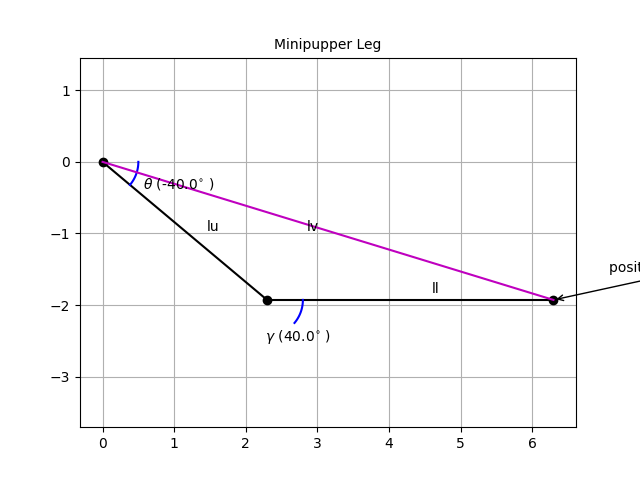

In [20]:
points = mpForwardKin(result)
print(points)
fig, ax = plt.subplots()
plt.xlim(-4,4) #<-- set the x axis limits
plt.ylim(-4,4) #<-- set the y axis limits
# plot a black point at the origin
plt.plot(0,0,'ok')
# plot upper leg
plt.plot([points[0,0],points[0,1]], [points[1,0], points[1,1]],'-k')
plt.text(points[0,1]/2+0.3, points[1,1]/2, 'lu')
# plot angle
angles = np.linspace(0, np.radians(result[0]))
xs = 0.5 * np.cos(angles)
ys = 0.5 * np.sin(angles)
plt.plot(xs, ys, '-b')
plt.text(xs[int(len(angles)/2)]+0.1, ys[int(len(angles)/2)]-0.2, "$\\theta$ (%s$^{\circ}$ )" % round(result[0],2))
# plot a black point at the joint between upper and lower leg
plt.plot(points[0,1],points[1,1],'ok')
# show coordinate system for lower leg
#points[:,0] = points[:,1]
#points[0,1] = float((lu_example+Lx_example).components.get(U.i, 0))
#points[1,1] = float((lu_example+Lx_example).components.get(U.j, 0))
#plt.plot(points[0], points[1],'-r')
#points[0,1] = float((lu_example+Ly_example).components.get(U.i, 0))
#points[1,1] = float((lu_example+Ly_example).components.get(U.j, 0))
#plt.plot(points[0], points[1],'-g')
# plot lower leg
plt.plot([points[0,1], points[0,2]], [points[1,1], points[1,2]],'-k')
plt.text((points[0,1]+points[0,2])/2+0.3, (points[1,1]+points[1,2])/2 + 0.1, 'll')
# plot angle
angles = np.linspace(np.radians(result[0]), np.radians(result[0])+np.radians(result[1]))
xs = points[0,1] + 0.5 * np.cos(angles)
ys = points[1,1] + 0.5 * np.sin(angles)
plt.plot(xs, ys, '-b')
plt.text(xs[int(len(angles)/2)]-0.5, ys[int(len(angles)/2)]-0.4, "$\gamma$ (%s$^{\circ}$ )" % round(result[1],2))
# plot a black point at the end of the lower leg
plt.plot(points[0,2],points[1,2],'ok')
ax.annotate(
    "position (%.4f, %.4f)" % (points[0,2],points[1,2]),
    xy=(points[0,2],points[1,2]), xycoords='data',
    xytext=(40, 20), textcoords='offset points',
    arrowprops=dict(arrowstyle="->"))

# plot a vector from the origin to the foot
new_points = np.zeros((2, 2))
new_points[0,1] = points[0,2]
new_points[1,1] = points[1,2]
plt.plot(new_points[0], new_points[1],'-m')
plt.text(new_points[0,1]/2-0.3, new_points[1,1]/2, 'lv')


plt.axis('equal')  #<-- set the axes to the same scale

plt.grid(visible=True, which='major')
plt.title('Minipupper Leg',fontsize=10)